# Credit Card Fraud Detection – Final Project  
**Savni Kothi**

In [1]:
# Load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)

df = pd.read_csv("creditcard.csv")

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
# Basic Data Checks
df.shape
df.info()
df.describe()
df["Class"].value_counts()
df["Class"].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

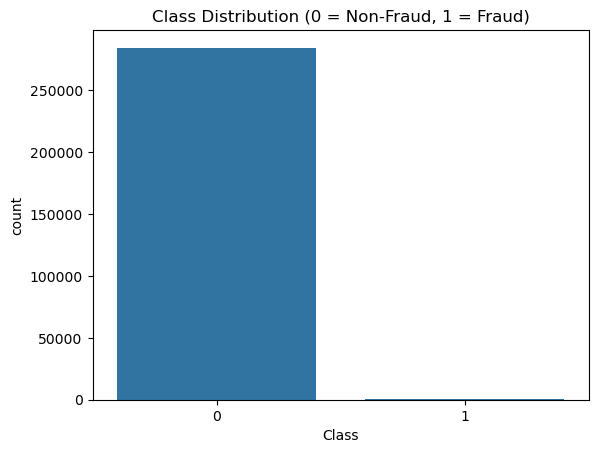

In [3]:
# Plot - Class Distribution 
sns.countplot(x="Class", data=df)
plt.title("Class Distribution (0 = Non-Fraud, 1 = Fraud)")
plt.show()

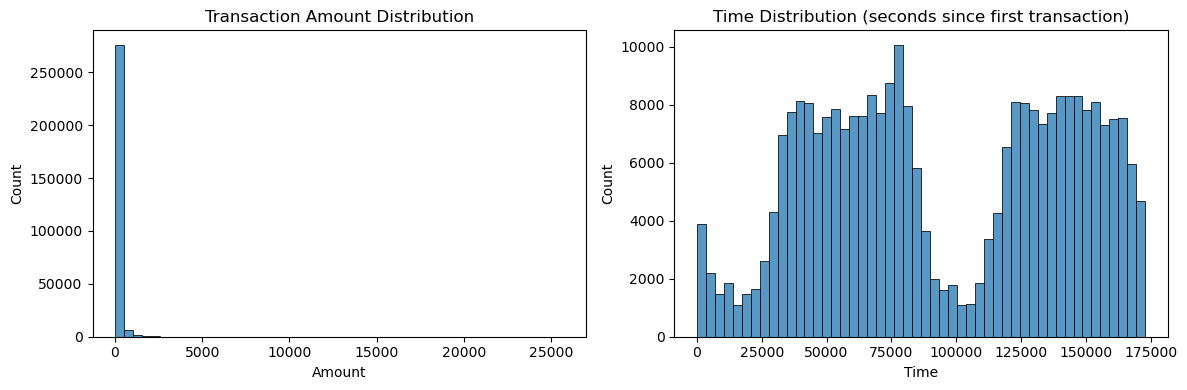

In [4]:
# Plot Amount and Time Distributions
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.histplot(df["Amount"], bins=50, ax=axes[0])
axes[0].set_title("Transaction Amount Distribution")

sns.histplot(df["Time"], bins=50, ax=axes[1])
axes[1].set_title("Time Distribution (seconds since first transaction)")

plt.tight_layout()
plt.show()

In [5]:
# Define Features(x) and Target(y)
X = df.drop("Class", axis=1)
y = df["Class"]

In [6]:
# Train / Validation / Test Split
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    stratify=y_temp,
    random_state=42
)

len(X_train), len(X_val), len(X_test)

(170883, 56962, 56962)

In [7]:
# Scale the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

In [8]:
# Quick check shapes and class balance
from collections import Counter

print("Train class distribution:", Counter(y_train))
print("Validation class distribution:", Counter(y_val))
print("Test class distribution:", Counter(y_test))

Train class distribution: Counter({0: 170588, 1: 295})
Validation class distribution: Counter({0: 56863, 1: 99})
Test class distribution: Counter({0: 56864, 1: 98})


In [9]:
# Train Logistic Regression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    class_weight="balanced",   
    max_iter=1000,
    n_jobs=-1,
    random_state=42
)

log_reg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=42)

In [19]:
# Helper function to evaluate a model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)

def evaluate_model(name, model, X_val, y_val):
    print(f"---- {name} ----")
    
    # Predictions and probabilities
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]

    # Text metrics
    print("Classification report:")
    print(classification_report(y_val, y_pred, digits=4))

    print("ROC-AUC:", roc_auc_score(y_val, y_prob))
    
    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix (Validation)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC curve
    RocCurveDisplay.from_predictions(y_val, y_prob)
    plt.title(f"{name} - ROC Curve (Validation)")
    plt.show()

---- Logistic Regression ----
Classification report:
              precision    recall  f1-score   support

           0     0.9998    0.9753    0.9874     56863
           1     0.0597    0.8990    0.1119        99

    accuracy                         0.9752     56962
   macro avg     0.5297    0.9372    0.5497     56962
weighted avg     0.9982    0.9752    0.9859     56962

ROC-AUC: 0.9747276681486976


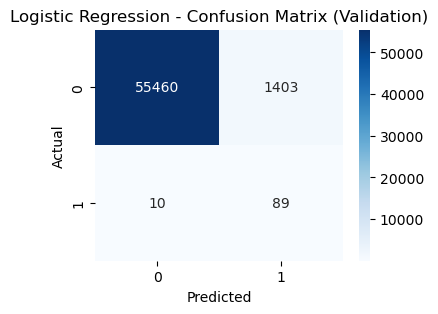

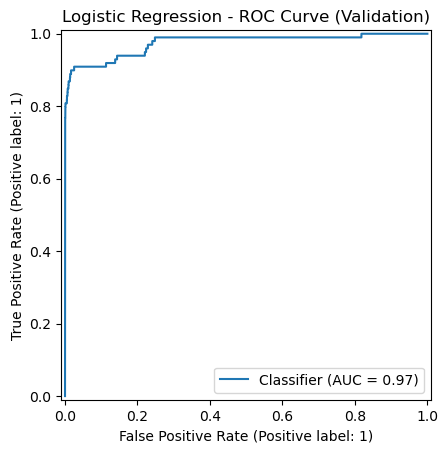

In [20]:
# Evaluate Logistic Regression on validation set
evaluate_model("Logistic Regression", log_reg, X_val_scaled, y_val)

In [21]:
# Train k-Nearest Neighbors (kNN) – try multiple k values
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

k_values = [3, 5, 7, 9, 11]
f1_scores = {}

for k in k_values:
    knn_temp = KNeighborsClassifier(
        n_neighbors=k,
        weights="distance"   
    )
    knn_temp.fit(X_train_scaled, y_train)
    y_val_pred = knn_temp.predict(X_val_scaled)
    f1 = f1_score(y_val, y_val_pred, pos_label=1)
    f1_scores[k] = f1
    print(f"k = {k}, validation F1 (fraud class) = {f1:.4f}")

k = 3, validation F1 (fraud class) = 0.7886
k = 5, validation F1 (fraud class) = 0.7816
k = 7, validation F1 (fraud class) = 0.7771
k = 9, validation F1 (fraud class) = 0.7910
k = 11, validation F1 (fraud class) = 0.7910


In [22]:
# Train final kNN model with the best k
best_k = max(f1_scores, key=f1_scores.get)
print("Best k:", best_k)

knn = KNeighborsClassifier(
    n_neighbors=best_k,
    weights="distance"
)

knn.fit(X_train_scaled, y_train)

Best k: 9


KNeighborsClassifier(n_neighbors=9, weights='distance')

---- kNN (k=9) ----
Classification report:
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.8974    0.7071    0.7910        99

    accuracy                         0.9994     56962
   macro avg     0.9485    0.8535    0.8953     56962
weighted avg     0.9993    0.9994    0.9993     56962

ROC-AUC: 0.8987911224514992


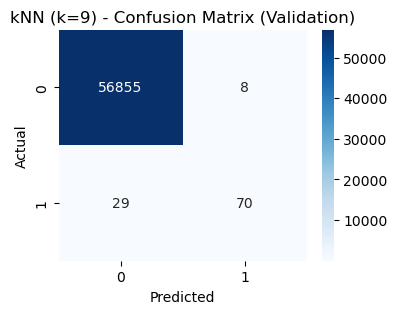

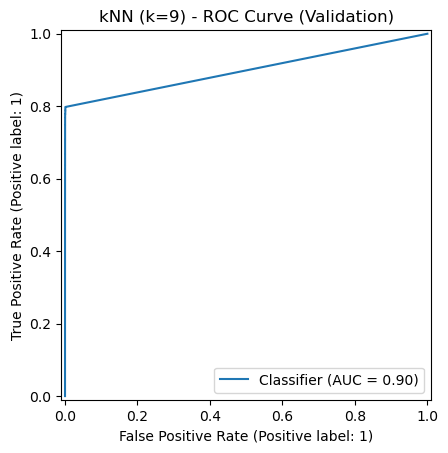

In [23]:
# Evaluate kNN on the validation set
evaluate_model(f"kNN (k={best_k})", knn, X_val_scaled, y_val)

----- TEST SET RESULTS ------
---- Logistic Regression (Test) ----
Classification report:
              precision    recall  f1-score   support

           0     0.9999    0.9759    0.9877     56864
           1     0.0616    0.9184    0.1155        98

    accuracy                         0.9758     56962
   macro avg     0.5307    0.9471    0.5516     56962
weighted avg     0.9982    0.9758    0.9862     56962

ROC-AUC: 0.9725522155260529


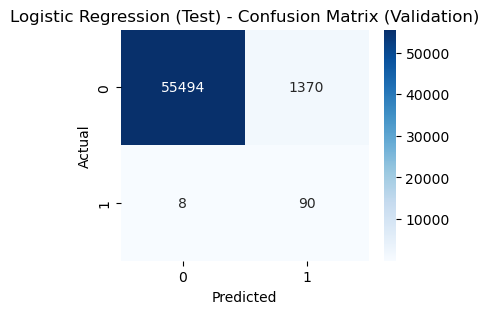

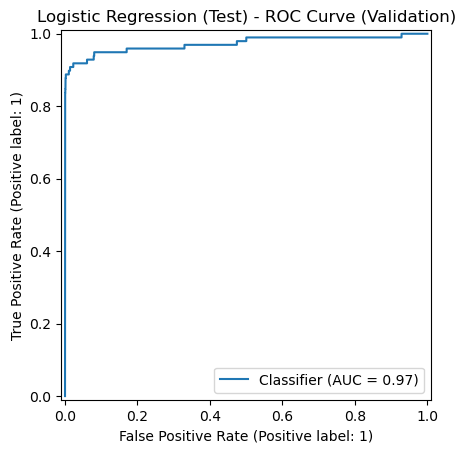

---- kNN (k=9) (Test) ----
Classification report:
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9997     56864
           1     0.9146    0.7653    0.8333        98

    accuracy                         0.9995     56962
   macro avg     0.9571    0.8826    0.9165     56962
weighted avg     0.9994    0.9995    0.9994     56962

ROC-AUC: 0.943682133095219


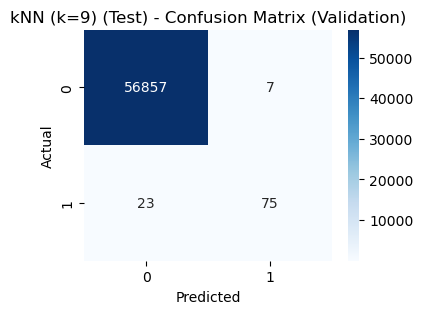

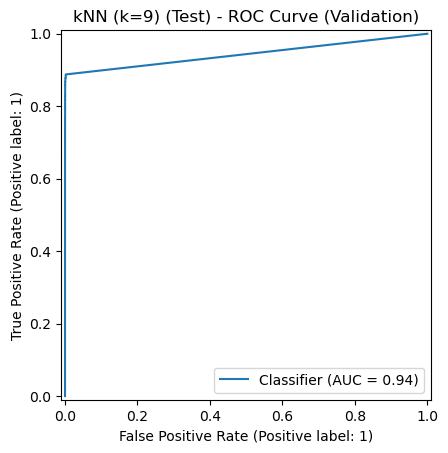

In [24]:
# Evaluate on the test set
print("----- TEST SET RESULTS ------")
evaluate_model("Logistic Regression (Test)", log_reg, X_test_scaled, y_test)
evaluate_model(f"kNN (k={best_k}) (Test)", knn, X_test_scaled, y_test)